In [101]:
import numpy as np
import pandas as pd
import open3d as o3d

import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [102]:
# Function to create transects based on theta2 values
def create_transects(dataframe, target_theta2_values, theta_range=1):
    return [dataframe[(dataframe['theta'] >= t - theta_range) & (dataframe['theta'] <= t + theta_range)] for t in target_theta2_values]

# Function to transform lidar point cloud to system coordinates
def transform_lidar(pcd_file, transformation_matrix):
    # Load point cloud data
    pcd = o3d.io.read_point_cloud(pcd_file)
    xyz = np.asarray(pcd.points)

    # Convert to spherical coordinates
    rho = np.linalg.norm(xyz, axis=1)
    theta_degrees = np.degrees(np.arccos(xyz[:, 2] / rho))

    # Create DataFrame with point cloud data and theta values
    point_cloud_df = pd.DataFrame(xyz, columns=['x', 'y', 'z'])
    point_cloud_df['theta'] = theta_degrees

    # Define target theta2 values and generate transects
    target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]
    transects = create_transects(point_cloud_df, target_theta2_values)

    # Check for unassigned points
    unassigned_points_count = len(point_cloud_df) - sum(len(transect) for transect in transects)
    if unassigned_points_count > 0:
        print(f"Unassigned points count: {unassigned_points_count}")

    # Select Transect 3 and remove lidar frame points
    transect_A = transects[2]
    transect_A = transect_A[~(
        ((transect_A['y'] >= -700) & (transect_A['y'] <= 200) & 
         (transect_A['x'] >= -1100) & (transect_A['x'] <= 4000)) |
        (transect_A['x'] < -2000)
    )]

    # Apply transformation matrix to go to RD coordinates
    homogeneous_coords = np.hstack((transect_A[['x', 'y', 'z']], np.ones((transect_A.shape[0], 1))))
    transformed_coords = homogeneous_coords.dot(transformation_matrix.T)

    # Store transformed coordinates in DataFrame df_RD
    df_RD = pd.DataFrame(transformed_coords[:, :3], columns=['x', 'y', 'z'])

    # Define offset for system coordinates
    offset = [71683.5843540416, 452356.054802959]
    angle_rad = np.radians(36)
    cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)

    # Transform to system coordinates
    df = pd.DataFrame({
        'x': (df_RD['x'] - offset[0]) * cos_angle - (df_RD['y'] - offset[1]) * sin_angle,
        'y': (df_RD['x'] - offset[0]) * sin_angle + (df_RD['y'] - offset[1]) * cos_angle,
        'z': df_RD['z']
    })

    # # Remove points where x is higher than 805
    df = df[df['x'] <= 809]
    
    # Remove points where z is higher than 3 and x is lower than 790
    df = df[~((df['z'] > 3) & (df['x'] < 790))]

    # Add point with x=809, y=290.4, z=4.95
    new_point = pd.DataFrame({'x': [809.75], 'y': [290.4], 'z': [5.0]})
    df = pd.concat([df, new_point], ignore_index=True)


    return df



## RD_coordinates to New_system_Coord ##

In [103]:
### S1 Dike in dune ###
offset = [71683.5843540416, 452356.054802959]
angle_rad = np.radians(36)
cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)

# dike section
teen = [72494.97, 452125.915, 1.01]
kruin = [72504.20, 452119.20, 4.70]

teen_ns = [0, 0, 0]
kruin_ns = [0, 0, 0]

teen_ns[0] = (teen[0] - offset[0]) * cos_angle - (teen[1] - offset[1]) * sin_angle
teen_ns[1] = (teen[0] - offset[0]) * sin_angle + (teen[1] - offset[1]) * cos_angle
teen_ns[2] = teen[2]

kruin_ns[0] = (kruin[0] - offset[0]) * cos_angle - (kruin[1] - offset[1]) * sin_angle
kruin_ns[1] = (kruin[0] - offset[0]) * sin_angle + (kruin[1] - offset[1]) * cos_angle
kruin_ns[2] = kruin[2]

print(teen_ns)
print(kruin_ns)

[791.6975587170695, 290.7335049401803, 1.01]
[803.1117635442716, 290.726213701636, 4.7]


## Transformation Matrix ##

In [104]:
# Transformation matrix storm 1\
# all gcp 
transformation_matrix1 = np.array([
    [-0.002199340612, 0.813549220562, -0.581491947174, 492.125885009766],
    [-0.003037251998, -0.581496119499, -0.813543498516, 127.405715942383],
    [-0.999992966652, -0.000023121676, 0.003749861848, 4.598251342773],
    [0.000000000000, 0.000000000000, 0.000000000000, 1.000000000000]
])

# minus gcp 1
# transformation_matrix1 = np.array([
#     [0.001410950790, 0.812377512455, -0.583130180836, 492.112091064453],
#     [0.000446705671, -0.583131194115, -0.812377870083, 127.382499694824],
#     [-0.999998927116, 0.000885737652, -0.001185663044, 4.607468605042],
#     [0.000000000000, 0.000000000000, 0.000000000000, 1.000000000000]
# ])
transformation_matrix1[0:3, 0:3] *= 0.001
transformation_matrix1[0,3]+=  72000.00 
transformation_matrix1[1,3]+=  452000.00
# print(transformation_matrix1)

# Transformation matrix storm 2

transformation_matrix2 = np.array([
    [-0.020505372435, 0.811702489853, -0.583711028099, 492.117889404297],
    [0.007382744923, -0.583694934845, -0.811939477921, 127.374443054199],
    [-0.999762475491, -0.020958511159, 0.005976289976, 4.593192100525],
    [0.000000000000, 0.000000000000, 0.000000000000, 1.000000000000]
])

transformation_matrix2[0:3, 0:3] *= 0.001
transformation_matrix2[0,3]+=  72000.00 
transformation_matrix2[1,3]+=  452000.00
# print(transformation_matrix2)

# Transformation matrix storm 3

transformation_matrix3= np.array([
    [-0.004158232361, 0.815255224705, -0.579086899757, 492.086791992188],
    [0.001722776797, -0.579085230827, -0.815265178680, 127.338287353516],
    [-0.999989867210, -0.004387699533, 0.001003468060, 4.552772045135],
    [0.000000000000, 0.000000000000, 0.000000000000, 1.000000000000]
])
transformation_matrix3[0:3, 0:3] *= 0.001
transformation_matrix3[0,3]+=  72000.00 
transformation_matrix3[1,3]+=  452000.00
# print(transformation_matrix2)


## PCD-Files ##

In [105]:
# storm 1
pcd_file1_1 = r"U:\2024-12-18 to 2024-12-20, Storm 1\Lidars\20241220_LiDAR1\10s interval data\Lidar1__Pcl_0019_12_2024__00_00_00.206.PCD"
pcd_file1_2 = r"U:\2024-12-18 to 2024-12-20, Storm 1\Lidars\20241220_LiDAR1\10s interval data\Lidar1__Pcl_0019_12_2024__13_00_00.209.PCD"
pcd_file1_3 = r"U:\2024-12-18 to 2024-12-20, Storm 1\Lidars\20241220_LiDAR1\10s interval data\Lidar1__Pcl_0020_12_2024__01_00_00.206.PCD"

df1_1 = transform_lidar(pcd_file1_1, transformation_matrix1)
df1_2 = transform_lidar(pcd_file1_2, transformation_matrix1)
df1_3 = transform_lidar(pcd_file1_3, transformation_matrix1)

In [106]:
# Storm 2 
pcd_file2_1 = r"U:\2024-12-22, Storm 2\Lidars\20241223_LiDAR1\10s interval data\Lidar1__Pcl_0022_12_2024__02_30_30.030.PCD"
pcd_file2_2 = r"U:\2024-12-22, Storm 2\Lidars\20241223_LiDAR1\10s interval data\Lidar1__Pcl_0022_12_2024__14_30_30.030.PCD"
pcd_file2_3 = r"U:\2024-12-22, Storm 2\Lidars\20241223_LiDAR1\10s interval data\Lidar1__Pcl_0023_12_2024__01_30_30.030.PCD"

df2_1 = transform_lidar(pcd_file2_1, transformation_matrix2)
df2_2 = transform_lidar(pcd_file2_2, transformation_matrix2)
df2_3 = transform_lidar(pcd_file2_3, transformation_matrix2)

In [107]:
# storm 3
pcd_file3_1 = r"U:\2025-01-01, Storm 3\Lidars\20250102_LiDAR1\10s interval data\lidar1__Pcl_0001_01_2025__11_20_00.245.PCD"
pcd_file3_2 = r"U:\2025-01-01, Storm 3\Lidars\20250102_LiDAR1\10s interval data\lidar1__Pcl_0001_01_2025__23_00_00.245.PCD"
pcd_file3_3 = r"U:\2025-01-01, Storm 3\Lidars\20250102_LiDAR1\10s interval data\lidar1__Pcl_0002_01_2025__07_30_00.245.PCD"
# pcd_file3_4 = r"U:\2025-01-01, Storm 3\Lidars\20250102_LiDAR1\10s interval data\lidar1__Pcl_0002_01_2025__23_00_00.245.PCD"

df3_1 = transform_lidar(pcd_file3_1, transformation_matrix3)
df3_2 = transform_lidar(pcd_file3_2, transformation_matrix3)
df3_3 = transform_lidar(pcd_file3_3, transformation_matrix3)
# df3_4 = transform_lidar(pcd_file3_4, transformation_matrix3)

## Plots ##

In [108]:
# create seismic colormap for 10 plot lines
cmap = plt.get_cmap('seismic')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]

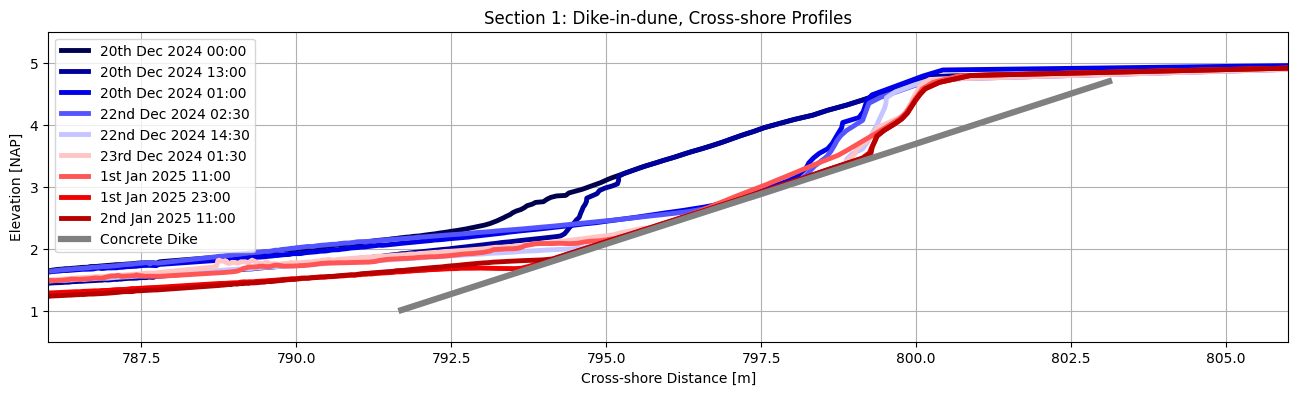

In [113]:
def interpolate_data(df):
    # Rotate the data 45 degrees counter-clockwise in the x-z plane
    df_rotated = df.copy()
    df_rotated['x'] = df['x'] * np.cos(np.radians(45)) - df['z'] * np.sin(np.radians(45))
    df_rotated['z'] = df['x'] * np.sin(np.radians(45)) + df['z'] * np.cos(np.radians(45))
    df_sorted = df_rotated.sort_values(by='z').reset_index(drop=True)
    z_interp = np.linspace(df_sorted['z'].min(), df_sorted['z'].max(), num=100000)
    f = interp1d(df_sorted['z'], df_sorted['x'], kind='linear', fill_value="extrapolate")
    x_interp = f(z_interp)
    # Rotate the interpolated data 45 degrees clockwise in the x-z plane
    x_interp, z_interp = rotate_clockwise_corrected(x_interp, z_interp)
    return x_interp, z_interp

# Corrected rotation function for rotating back to the original position
def rotate_clockwise_corrected(x, z):
    x_rotated = x * np.cos(np.radians(45)) + z * np.sin(np.radians(45))
    z_rotated = -x * np.sin(np.radians(45)) + z * np.cos(np.radians(45))
    return x_rotated, z_rotated

# Assuming df1_1, df1_2, etc., are defined DataFrames
dataframes = [df1_1, df1_2, df1_3, df2_1, df2_2, df2_3, df3_1, df3_2, df3_3]

# create seismic colormap for 10 plot lines
cmap = plt.get_cmap('seismic')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]

# Interpolating data using the provided function
interpolated_data = [interpolate_data(df) for df in dataframes]

# Perform interpolation for each dataframe
x_interp_df1_1, z_interp_df1_1 = interpolate_data(df1_1)
x_interp_df1_2, z_interp_df1_2 = interpolate_data(df1_2)
x_interp_df1_3, z_interp_df1_3 = interpolate_data(df1_3)

x_interp_df2_1, z_interp_df2_1 = interpolate_data(df2_1)
x_interp_df2_2, z_interp_df2_2 = interpolate_data(df2_2)
x_interp_df2_3, z_interp_df2_3 = interpolate_data(df2_3)

x_interp_df3_1, z_interp_df3_1 = interpolate_data(df3_1)
x_interp_df3_2, z_interp_df3_2 = interpolate_data(df3_2)
x_interp_df3_3, z_interp_df3_3 = interpolate_data(df3_3)
# x_interp_df3_4, z_interp_df3_4 = interpolate_data(df3_4)

# Plot the original and interpolated data
plt.figure(figsize=(16, 8))

# Plot original data
# plt.scatter(df1_1['x'], df1_1['z'], color=colors[0], label='20th Dec 2024 00:00')
# plt.scatter(df1_2['x'], df1_2['z'], color=colors[1], label='20th Dec 2024 13:00')
# plt.scatter(df1_3['x'], df1_3['z'], color=colors[2], label='20th Dec 2024 01:00')

# plt.scatter(df2_1['x'], df2_1['z'], color=colors[3], label='22nd Dec 2024 02:30')
# plt.scatter(df2_2['x'], df2_2['z'], color=colors[4], label='22nd Dec 2024 14:30')
# plt.scatter(df2_3['x'], df2_3['z'], color=colors[5], label='23rd Dec 2024 01:30')

# plt.scatter(df3_1['x'], df3_1['z'], color=colors[6], label='1st Jan 2025 11:00')
# plt.scatter(df3_2['x'], df3_2['z'], color=colors[7], label='1st Jan 2025 23:00')
# plt.scatter(df3_3['x'], df3_3['z'], color=colors[8], label='2nd Jan 2025 11:00')
# plt.scatter(df3_4['x'], df3_4['z'], color=colors[9], label='2nd Jan 2025 23:00')

# Plot interpolated data
LW = 3.5

plt.plot(x_interp_df1_1, z_interp_df1_1, color=colors[0], linestyle='-', linewidth=LW, label='20th Dec 2024 00:00')
plt.plot(x_interp_df1_2, z_interp_df1_2, color=colors[1], linestyle='-', linewidth=LW, label='20th Dec 2024 13:00')
plt.plot(x_interp_df1_3, z_interp_df1_3, color=colors[2], linestyle='-', linewidth=LW, label='20th Dec 2024 01:00')

plt.plot(x_interp_df2_1, z_interp_df2_1, color=colors[3], linestyle='-', linewidth=LW, label='22nd Dec 2024 02:30')
plt.plot(x_interp_df2_2, z_interp_df2_2, color=colors[4], linestyle='-', linewidth=LW, label='22nd Dec 2024 14:30')
plt.plot(x_interp_df2_3, z_interp_df2_3, color=colors[5], linestyle='-', linewidth=LW, label='23rd Dec 2024 01:30')

plt.plot(x_interp_df3_1, z_interp_df3_1, color=colors[6], linestyle='-', linewidth=LW, label='1st Jan 2025 11:00')
plt.plot(x_interp_df3_2, z_interp_df3_2, color=colors[7], linestyle='-', linewidth=LW, label='1st Jan 2025 23:00')
plt.plot(x_interp_df3_3, z_interp_df3_3, color=colors[8], linestyle='-', linewidth=LW, label='2nd Jan 2025 11:00')
# plt.plot(x_interp_df3_4, z_interp_df3_4, color=colors[9], linestyle='-', linewidth=LW, label='2nd Jan 2025 23:00')

plt.xlabel('Cross-shore Distance [m]')
plt.ylabel('Elevation [NAP]')
plt.title('Section 1: Dike-in-dune, Cross-shore Profiles')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')



# Plot line through teen_ns and kruin_ns
x = [teen_ns[0], kruin_ns[0]]
y = [teen_ns[2], kruin_ns[2]]
plt.plot(x, y, color='grey', linewidth=4.5, label='Concrete Dike')

# plt.axvline(x=790, linestyle='--')
# plt.axvline(x=805, linestyle='--')
# plt.axvline(x=796.7, linestyle='--')

plt.xlim(786, 806)
plt.ylim(0.5, 5.5)
plt.legend(loc='upper left')
plt.show()


## Accretion and Erosion ##

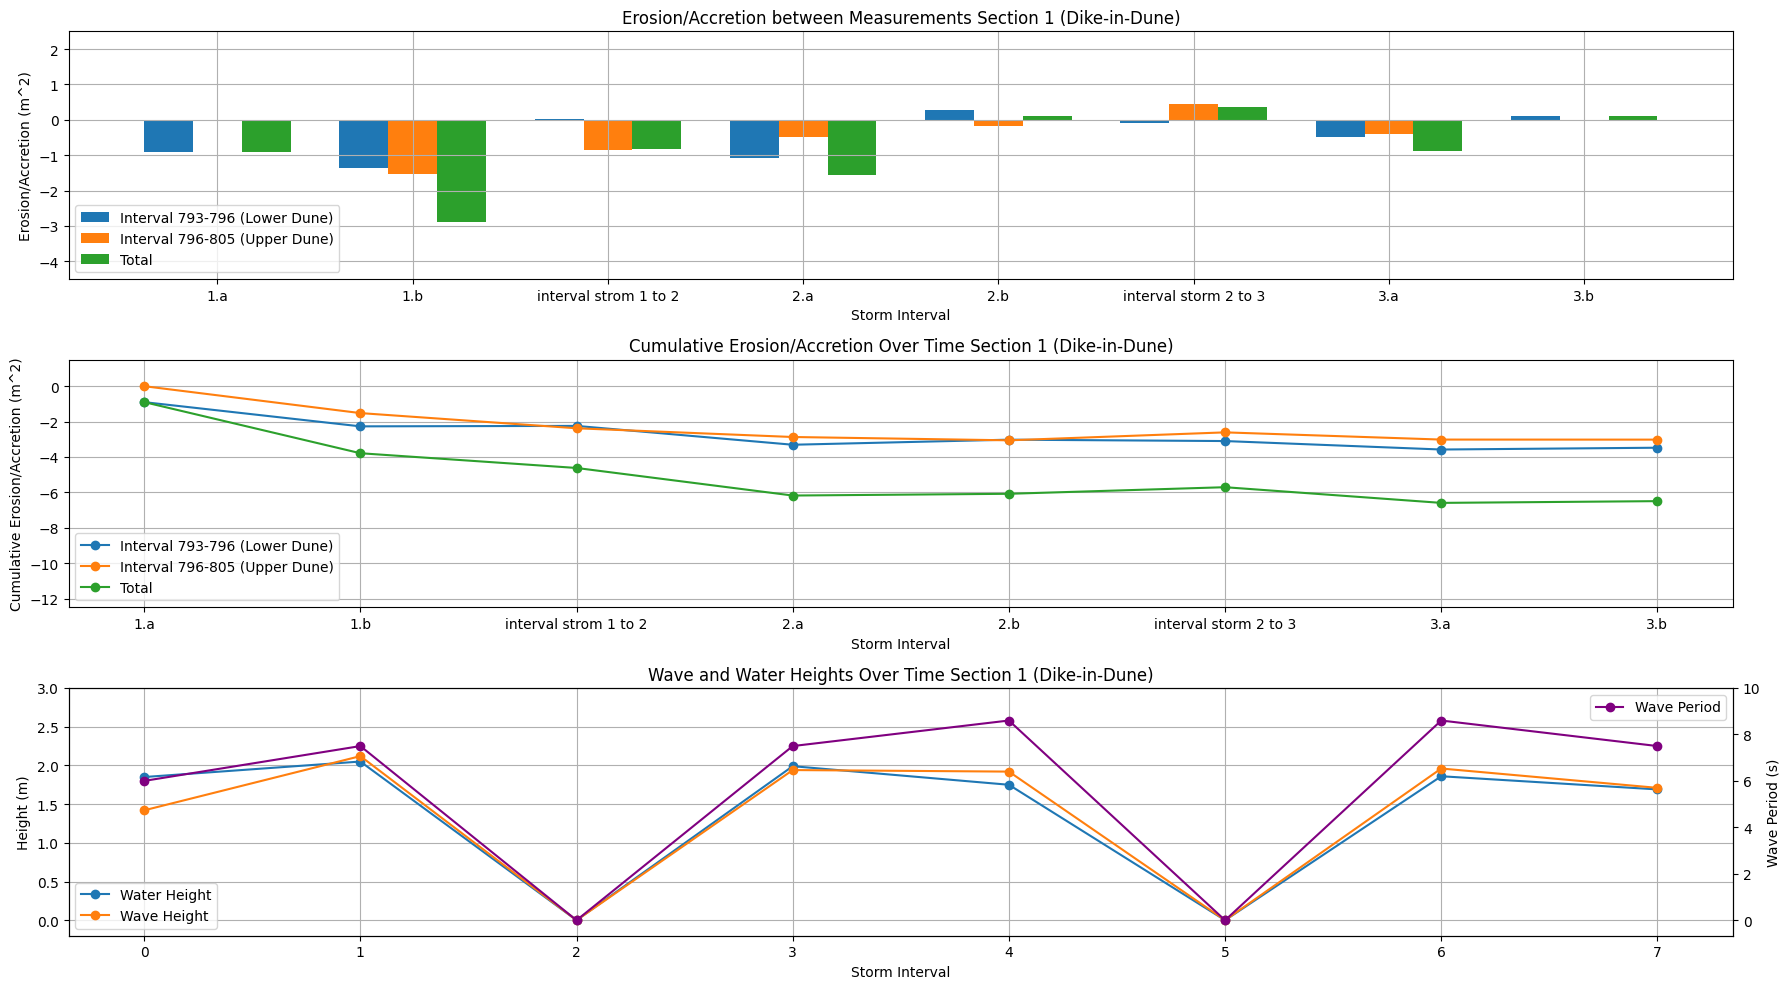

In [115]:
# Function to calculate area under the curve using interpolated data
def calculate_area(x_interp, z_interp, x_start, x_end):
    # Select the interpolated data within the specified range
    mask = (x_interp >= x_start) & (x_interp <= x_end)
    x_selected = x_interp[mask]
    z_selected = z_interp[mask]
    # Calculate the area using the trapezoidal rule
    area = np.trapz(z_selected, x_selected)
    return area

# Calculate areas for both intervals
x_start1, x_end1 = 793, 796.7
x_start2, x_end2 = 796.7, 805

areas1 = [calculate_area(x_interp, z_interp, x_start1, x_end1) for x_interp, z_interp in interpolated_data]
areas2 = [calculate_area(x_interp, z_interp, x_start2, x_end2) for x_interp, z_interp in interpolated_data]

# Calculate erosion/accretion for both intervals
erosion_accretion1 = np.diff(areas1)
erosion_accretion2 = np.diff(areas2)
erosion_accretion_total = erosion_accretion1 + erosion_accretion2

# Calculate cumulative erosion/accretion for both intervals
cumulative_erosion_accretion1 = np.cumsum(erosion_accretion1)
cumulative_erosion_accretion2 = np.cumsum(erosion_accretion2)
cumulative_erosion_accretion_total = cumulative_erosion_accretion1 + cumulative_erosion_accretion2

# Wave and water heights for each storm interval
water_heights= [1.85, 2.05, 0.0, 1.99, 1.75, 0.0, 1.86, 1.69]
wave_heights = [1.42, 2.12, 0.0, 1.94, 1.92, 0.0, 1.96, 1.71]
wave_periods = [6.0, 7.5, 0.0, 7.5, 8.6, 0.0, 8.6, 7.5]

# Plotting
fig, ax1 = plt.subplots(3, 1, figsize=(18, 10))

# Bar plot for both intervals side by side
bar_width = 0.25
indices = np.arange(len(erosion_accretion1))
ax1[0].bar(indices - bar_width, erosion_accretion1, bar_width, label='Interval 793-796 (Lower Dune)')
ax1[0].bar(indices, erosion_accretion2, bar_width, label='Interval 796-805 (Upper Dune)')
ax1[0].bar(indices + bar_width, erosion_accretion_total, bar_width, label='Total')
ax1[0].set_title('Erosion/Accretion between Measurements Section 1 (Dike-in-Dune)')
ax1[0].set_xlabel('Storm Interval')
ax1[0].set_ylabel('Erosion/Accretion (m^2)')
ax1[0].grid(True)
ax1[0].legend(loc='lower left')
ax1[0].set_ylim(-4.5, 2.5)

# Cumulative plot for both intervals and their sum
ax1[1].plot(range(len(cumulative_erosion_accretion1)), cumulative_erosion_accretion1, marker='o', label='Interval 793-796 (Lower Dune)')
ax1[1].plot(range(len(cumulative_erosion_accretion2)), cumulative_erosion_accretion2, marker='o', label='Interval 796-805 (Upper Dune)')
ax1[1].plot(range(len(cumulative_erosion_accretion_total)), cumulative_erosion_accretion_total, marker='o', label='Total')
ax1[1].set_title('Cumulative Erosion/Accretion Over Time Section 1 (Dike-in-Dune)')
ax1[1].set_xlabel('Storm Interval')
ax1[1].set_ylabel('Cumulative Erosion/Accretion (m^2)')
ax1[1].grid(True)
ax1[1].legend(loc='lower left')
ax1[1].set_ylim(-12.5, 1.5)

# wave and water heights
ax1[2].plot(range(len(water_heights)), water_heights, marker='o', label='Water Height')
ax1[2].plot(range(len(wave_heights)), wave_heights, marker='o', label='Wave Height')
ax2 = ax1[2].twinx()
ax2.plot(range(len(wave_periods)), wave_periods, marker='o', color='purple', label='Wave Period')
ax2.set_ylabel('Wave Period (s)')
ax2.set_ylim(-0.666, 10)
ax2.legend(loc='upper right')
ax1[2].set_title('Wave and Water Heights Over Time Section 1 (Dike-in-Dune)')
ax1[2].set_xlabel('Storm Interval')
ax1[2].set_ylabel('Height (m)')
ax1[2].set_ylim(-0.2, 3)
ax1[2].grid(True)
ax1[2].legend(loc='lower left')

# Set custom x-ticks for both subplots
x_ticks_labels = ['1.a', '1.b', 'interval strom 1 to 2', '2.a', '2.b', 'interval storm 2 to 3', '3.a', '3.b']
ax1[0].set_xticks(indices)
ax1[0].set_xticklabels(x_ticks_labels)
ax1[1].set_xticks(range(len(x_ticks_labels)))
ax1[1].set_xticklabels(x_ticks_labels)

plt.tight_layout()
plt.show()

# print(areas1)
# print(areas2)


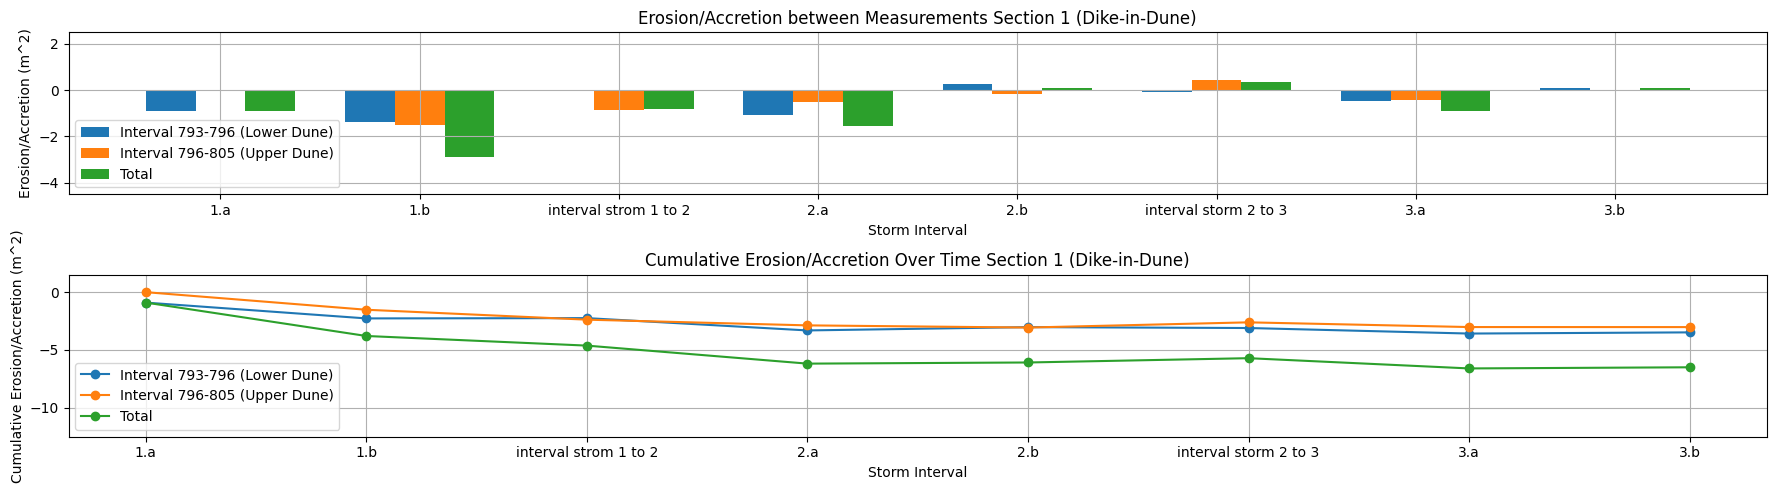

In [118]:
# Plotting
fig, ax1 = plt.subplots(2, 1, figsize=(18, 5))

# Bar plot for both intervals side by side
bar_width = 0.25
indices = np.arange(len(erosion_accretion1))
ax1[0].bar(indices - bar_width, erosion_accretion1, bar_width, label='Interval 793-796 (Lower Dune)')
ax1[0].bar(indices, erosion_accretion2, bar_width, label='Interval 796-805 (Upper Dune)')
ax1[0].bar(indices + bar_width, erosion_accretion_total, bar_width, label='Total')
ax1[0].set_title('Erosion/Accretion between Measurements Section 1 (Dike-in-Dune)')
ax1[0].set_xlabel('Storm Interval')
ax1[0].set_ylabel('Erosion/Accretion (m^2)')
ax1[0].grid(True)
ax1[0].legend(loc='lower left')
ax1[0].set_ylim(-4.5, 2.5)

# Cumulative plot for both intervals and their sum
ax1[1].plot(range(len(cumulative_erosion_accretion1)), cumulative_erosion_accretion1, marker='o', label='Interval 793-796 (Lower Dune)')
ax1[1].plot(range(len(cumulative_erosion_accretion2)), cumulative_erosion_accretion2, marker='o', label='Interval 796-805 (Upper Dune)')
ax1[1].plot(range(len(cumulative_erosion_accretion_total)), cumulative_erosion_accretion_total, marker='o', label='Total')
ax1[1].set_title('Cumulative Erosion/Accretion Over Time Section 1 (Dike-in-Dune)')
ax1[1].set_xlabel('Storm Interval')
ax1[1].set_ylabel('Cumulative Erosion/Accretion (m^2)')
ax1[1].grid(True)
ax1[1].legend(loc='lower left')
ax1[1].set_ylim(-12.5, 1.5)

# wave and water heights
# ax1[2].plot(range(len(water_heights)), water_heights, marker='o', label='Water Height')
# ax1[2].plot(range(len(wave_heights)), wave_heights, marker='o', label='Wave Height')
# ax2 = ax1[2].twinx()
# ax2.plot(range(len(wave_periods)), wave_periods, marker='o', color='purple', label='Wave Period')
# ax2.set_ylabel('Wave Period (s)')
# ax2.set_ylim(-0.666, 10)
# ax2.legend(loc='upper right')
# ax1[2].set_title('Wave and Water Heights Over Time Section 1 (Dike-in-Dune)')
# ax1[2].set_xlabel('Storm Interval')
# ax1[2].set_ylabel('Height (m)')
# ax1[2].set_ylim(-0.2, 3)
# ax1[2].grid(True)
# ax1[2].legend(loc='lower left')

# Set custom x-ticks for both subplots
x_ticks_labels = ['1.a', '1.b', 'interval strom 1 to 2', '2.a', '2.b', 'interval storm 2 to 3', '3.a', '3.b']
ax1[0].set_xticks(indices)
ax1[0].set_xticklabels(x_ticks_labels)
ax1[1].set_xticks(range(len(x_ticks_labels)))
ax1[1].set_xticklabels(x_ticks_labels)

plt.tight_layout()
plt.show()

# print(areas1)
# print(areas2)


In [111]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

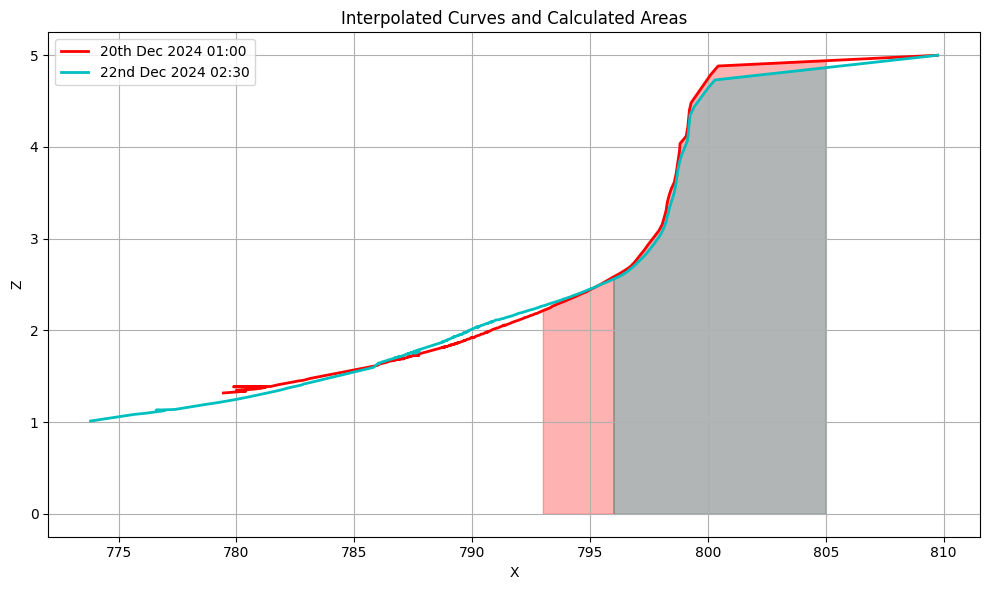

In [ ]:
# # Function to calculate area under the curve using interpolated data
# def calculate_area(x_interp, z_interp, x_start, x_end):
#     # Select the interpolated data within the specified range
#     mask = (x_interp >= x_start) & (x_interp <= x_end)
#     x_selected = x_interp[mask]
#     z_selected = z_interp[mask]
#     # Calculate the area using the trapezoidal rule
#     area = np.trapz(z_selected, x_selected)
#     return area, x_selected, z_selected

# # Calculate areas for both intervals for df1_3 and df2_1
# x_start1, x_end1 = 793, 796
# x_start2, x_end2 = 796, 805

# area1_df1_3, x_selected1_df1_3, z_selected1_df1_3 = calculate_area(x_interp_df1_3, z_interp_df1_3, x_start1, x_end1)
# area2_df1_3, x_selected2_df1_3, z_selected2_df1_3 = calculate_area(x_interp_df1_3, z_interp_df1_3, x_start2, x_end2)

# area1_df2_1, x_selected1_df2_1, z_selected1_df2_1 = calculate_area(x_interp_df2_1, z_interp_df2_1, x_start1, x_end1)
# area2_df2_1, x_selected2_df2_1, z_selected2_df2_1 = calculate_area(x_interp_df2_1, z_interp_df2_1, x_start2, x_end2)

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# # Define colors and line width
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# LW = 2

# # Plot interpolated curves
# ax.plot(x_interp_df1_3, z_interp_df1_3, color=colors[2], linestyle='-', linewidth=LW, label='20th Dec 2024 01:00')
# ax.plot(x_interp_df2_1, z_interp_df2_1, color=colors[3], linestyle='-', linewidth=LW, label='22nd Dec 2024 02:30')

# # Plot shaded areas for the calculated regions
# ax.fill_between(x_selected1_df1_3, z_selected1_df1_3, color=colors[2], alpha=0.3)
# ax.fill_between(x_selected2_df1_3, z_selected2_df1_3, color=colors[2], alpha=0.3)
# # ax.fill_between(x_selected1_df2_1, z_selected1_df2_1, color=colors[3], alpha=0.3)
# ax.fill_between(x_selected2_df2_1, z_selected2_df2_1, color=colors[3], alpha=0.3)

# # Add labels and legend
# ax.set_title('Interpolated Curves and Calculated Areas')
# ax.set_xlabel('X')
# ax.set_ylabel('Z')
# ax.legend()
# ax.grid(True)

# # plt.xlim(803,805)

# plt.tight_layout()
# plt.show()


In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


# Function to calculate the area under the curve using the trapezoidal rule
def calculate_area(x_interp, z_interp, x_start, x_end):
    mask = (x_interp >= x_start) & (x_interp <= x_end)
    x_selected = x_interp[mask]
    z_selected = z_interp[mask]
    area = np.trapz(z_selected, x_selected)
    return area

# Calculate areas for each interpolated data
areas1 = {}
areas2 = {}

dates = [
    '20 Dec 2024 00:00', '20 Dec 2024 13:00', '20 Dec 2024 01:00',
    '22 Dec 2024 02:30', '22 Dec 2024 14:30', '23 Dec 2024 01:30',
    '1 Jan 2025 11:00', '1 Jan 2025 23:00', '2 Jan 2025 11:00'
]

interpolated_data = [
    z_interp_df1_1, z_interp_df1_2, z_interp_df1_3,
    z_interp_df2_1, z_interp_df2_2, z_interp_df2_3,
    z_interp_df3_1, z_interp_df3_2, z_interp_df3_3
]

for date, z_interp in zip(dates, interpolated_data):
    areas1[date] = calculate_area(x_interp, z_interp, 770, 790)
    areas2[date] = calculate_area(x_interp, z_interp, 790, 803)

# Extract dates and areas for plotting
areas1_values = list(areas1.values())
areas2_values = list(areas2.values())

# Convert dates to datetime objects and sort them
date_format = "%d %b %Y %H:%M"
dates_converted = [datetime.datetime.strptime(date, date_format) for date in dates]

# Sort dates and corresponding values
sorted_indices = np.argsort(dates_converted)
dates_sorted = np.array(dates_converted)[sorted_indices]
areas1_sorted = np.array(areas1_values)[sorted_indices]
areas2_sorted = np.array(areas2_values)[sorted_indices]

# Calculate differences between each timestamp for both areas
differences1 = np.diff(areas1_sorted, prepend=areas1_sorted[0])
differences2 = np.diff(areas2_sorted, prepend=areas2_sorted[0])

# Calculate cumulative sedimentation/erosion for both areas
cumulative_areas1 = np.cumsum(differences1)
cumulative_areas2 = np.cumsum(differences2)

# Calculate total cumulative sedimentation/erosion
total_cumulative_sedimentation_erosion = cumulative_areas1 + cumulative_areas2

# Plot the cumulative sedimentation/erosion vs the time
plt.figure(figsize=(16, 4))
plt.plot(dates_sorted, cumulative_areas1, marker='x', linestyle='--', color='g', label='Cumulative Area 770-790 (m^2)')
plt.plot(dates_sorted, cumulative_areas2, marker='x', linestyle='--', color='r', label='Cumulative Area 790-803 (m^2)')
plt.plot(dates_sorted, total_cumulative_sedimentation_erosion, marker='o', linestyle='-', color='b', label='Total Cumulative Sedimentation/Erosion (m^2)')
plt.xlabel('Date')
plt.ylabel('Cumulative Sedimentation/Erosion (m^2)')
plt.title('Cumulative Sedimentation/Erosion vs Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 100000 but corresponding boolean dimension is 1000

In [ ]:
from scipy.stats import linregress

# Function to calculate detailed slope using linear regression
def detailed_slope(x_interp, z_interp, x1=770, x2=790):
    # Select the points between x1 and x2
    mask = (x_interp >= x1) & (x_interp <= x2)
    x_selected = x_interp[mask]
    z_selected = z_interp[mask]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_selected, z_selected)
    return slope, intercept, r_value, p_value, std_err

# Calculate detailed slopes for each interpolated data
detailed_slopes = {
    '20th Dec 2024 00:00': detailed_slope(x_interp, z_interp_df1_1),
    '20th Dec 2024 13:00': detailed_slope(x_interp, z_interp_df1_2),
    '20th Dec 2024 01:00': detailed_slope(x_interp, z_interp_df1_3),
    '22nd Dec 2024 02:30': detailed_slope(x_interp, z_interp_df2_1),
    '22nd Dec 2024 14:30': detailed_slope(x_interp, z_interp_df2_2),
    '23rd Dec 2024 01:30': detailed_slope(x_interp, z_interp_df2_3),
    '1st Jan 2025 11:00': detailed_slope(x_interp, z_interp_df3_1),
    '1st Jan 2025 23:00': detailed_slope(x_interp, z_interp_df3_2),
    '2nd Jan 2025 11:00': detailed_slope(x_interp, z_interp_df3_3),
}

# detailed_slopes


In [ ]:
# Print detailed slope calculations individually

detailed_slope_statements = {
    '20th Dec 2024 00:00': "20th Dec 2024 00:00:\n  - Slope: {:.4f}\n  - Intercept: {:.4f}\n  - R-value: {:.4f}\n  - P-value: {:.4f}\n  - Standard error: {:.4f}".format(*detailed_slopes['20th Dec 2024 00:00']),
    '20th Dec 2024 13:00': "20th Dec 2024 13:00:\n  - Slope: {:.4f}\n  - Intercept: {:.4f}\n  - R-value: {:.4f}\n  - P-value: {:.4f}\n  - Standard error: {:.4f}".format(*detailed_slopes['20th Dec 2024 13:00']),
    '20th Dec 2024 01:00': "20th Dec 2024 01:00:\n  - Slope: {:.4f}\n  - Intercept: {:.4f}\n  - R-value: {:.4f}\n  - P-value: {:.4e}\n  - Standard error: {:.4f}".format(*detailed_slopes['20th Dec 2024 01:00']),
    '22nd Dec 2024 02:30': "22nd Dec 2024 02:30:\n  - Slope: {:.4f}\n  - Intercept: {:.4f}\n  - R-value: {:.4f}\n  - P-value: {:.4e}\n  - Standard error: {:.4f}".format(*detailed_slopes['22nd Dec 2024 02:30']),
    '22nd Dec 2024 14:30': "22nd Dec 2024 14:30:\n  - Slope: {:.4f}\n  - Intercept: {:.4f}\n  - R-value: {:.4f}\n  - P-value: {:.4e}\n  - Standard error: {:.4f}".format(*detailed_slopes['22nd Dec 2024 14:30']),
    '23rd Dec 2024 01:30': "23rd Dec 2024 01:30:\n  - Slope: {:.4f}\n  - Intercept: {:.4f}\n  - R-value: {:.4f}\n  - P-value: {:.4f}\n  - Standard error: {:.4f}".format(*detailed_slopes['23rd Dec 2024 01:30']),
    '1st Jan 2025 11:00': "1st Jan 2025 11:00:\n  - Slope: {:.4f}\n  - Intercept: {:.4f}\n  - R-value: {:.4f}\n  - P-value: {:.4f}\n  - Standard error: {:.4f}".format(*detailed_slopes['1st Jan 2025 11:00']),
    '1st Jan 2025 23:00': "1st Jan 2025 23:00:\n  - Slope: {:.4f}\n  - Intercept: {:.4f}\n  - R-value: {:.4f}\n  - P-value: {:.4f}\n  - Standard error: {:.4f}".format(*detailed_slopes['1st Jan 2025 23:00']),
    '2nd Jan 2025 11:00': "2nd Jan 2025 11:00:\n  - Slope: {:.4f}\n  - Intercept: {:.4f}\n  - R-value: {:.4f}\n  - P-value: {:.4e}\n  - Standard error: {:.4f}".format(*detailed_slopes['2nd Jan 2025 11:00']),
}

# Print each statement
for key, statement in detailed_slope_statements.items():
    print(statement)
    print()

# Information about linregress function and its output parameters
linregress_info = """
The linregress function performs a linear regression on two sets of measurements. It computes several statistics that describe the relationship between the two sets of data.

Here are the output parameters of the linregress function:

1. Slope:
   - The rate of change of the dependent variable (y) with respect to the independent variable (x). It represents the steepness of the line.

2. Intercept:
   - The point where the regression line crosses the y-axis. It is the value of y when x is zero.

3. R-value:
   - The correlation coefficient, which measures the strength and direction of the linear relationship between the two variables. It ranges from -1 to 1. An R-value close to 1 or -1 indicates a strong linear relationship, while an R-value close to 0 indicates a weak linear relationship.

4. P-value:
   - The probability that the observed correlation occurred by chance. A small p-value (typically less than 0.05) indicates that the observed correlation is statistically significant.

5. Standard error:
   - The standard deviation of the sampling distribution of the slope. It provides an estimate of the accuracy of the slope. A smaller standard error indicates a more precise estimate of the slope.
"""

print(linregress_info)
